In [1]:
import requests
import pandas as pd
import json
import config
import warnings
warnings.filterwarnings("ignore")

from elasticsearch import Elasticsearch

## Helper

In [2]:
def divider(n=1):
    for i in range(n):
        print("-" * 20)

## load data from ES

In [3]:
user_name, pw = config.ES_USERNAME, config.ES_PASSWORD

In [4]:
# Connect to Elasticsearch
es = Elasticsearch("https://127.0.0.1:9200", basic_auth=(user_name, pw), verify_certs=False)

# check the index list
indices = es.cat.indices(index='*', h='index', format='json')

In [5]:
for index in indices:
    print(index)

{'index': 'rent'}
{'index': 'family_and_community_2011_2016'}
{'index': 'economy_and_industry_2014-2019'}
{'index': 'twitter_data'}
{'index': 'property_price'}
{'index': 'income'}
{'index': '2021_lga_settlement_reports_permanent_settlers_by_migration_stream'}
{'index': 'mortgage'}
{'index': 'building_approvals2011-2020'}
{'index': 'selected_medians_and_averages_2011_2016_2021'}
{'index': 'observations'}
{'index': 'housing_price'}
{'index': 'students'}
{'index': 'visa'}
{'index': 'income_2014-2019'}
{'index': 'migration'}
{'index': 'immigration'}
{'index': 'as4_median_housing_price2010_2014'}
{'index': 'rental_price'}
{'index': 'studying'}


In [13]:
# loading all the data
raw_data = {}

def contain_region(vars_: list):
    for var in vars_:
        var = var.lower()
        if "lga" in var or "sa4" in var:
            return True
    return False

# query = {
#     "query": {
#         "match_all": {}
#     }
# }
for item in indices:
    query = {
        "query": {
            "match_all": {}
        }
    }
    index_ = item['index']
    print(f"retrieving index {index_}")
    # Grab the exact size of the dataset, elasticSearch default only returns 10
    temp_response = es.search(index=index_, body=query)
    
    # only grabbing sudo data
    try:
        vars_ = temp_response['hits']['hits'][0]['_source']
    except IndexError:
        print("no data in the index, aborting...")
        divider()
        continue
    if not contain_region(vars_): 
        print("not an sudo index, aborting...")
        divider()
        continue
    
    index_size = temp_response['hits']['total']['value']

    # Retrieve the full dataset
    full_response = es.search(
        index=index_, 
        body=query,
        size=index_size
    )

    raw_data[index_] = full_response['hits']['hits']

    divider()

retrieving index rent
not an sudo index, aborting...
--------------------
retrieving index family_and_community_2011_2016
--------------------
retrieving index economy_and_industry_2014-2019
--------------------
retrieving index twitter_data
not an sudo index, aborting...
--------------------
retrieving index property_price
no data in the index, aborting...
--------------------
retrieving index income
not an sudo index, aborting...
--------------------
retrieving index 2021_lga_settlement_reports_permanent_settlers_by_migration_stream
--------------------
retrieving index mortgage
not an sudo index, aborting...
--------------------
retrieving index building_approvals2011-2020
--------------------
retrieving index selected_medians_and_averages_2011_2016_2021
--------------------
retrieving index observations
not an sudo index, aborting...
--------------------
retrieving index housing_price
not an sudo index, aborting...
--------------------
retrieving index students
not an sudo index, a

In [14]:
len(raw_data)

7

## Transform data into table form and put into pandas dataframe for easier analysis

In [11]:
raw_data.keys()

dict_keys(['family_and_community_2011_2016', 'economy_and_industry_2014-2019', '2021_lga_settlement_reports_permanent_settlers_by_migration_stream', 'building_approvals2011-2020', 'selected_medians_and_averages_2011_2016_2021', 'income_2014-2019', 'as4_median_housing_price2010_2014'])

In [70]:
all_sudo_data = {}

for index, raw_data_ in raw_data.items():
    raw_data_ = [item['_source'] for item in raw_data_]
    all_sudo_data[index] = raw_data_

df_sudo_data = {}
for index, data_ in all_sudo_data.items():
    df_sudo_data[index] = pd.DataFrame(data_)

In [71]:
# decode col names:
var_definitions = {}

data_definitions = get_ipython().getoutput('ls ./data_definition')

for data_definition in data_definitions:
    with open('./data_definition/' + data_definition, 'r') as f:
        temp_file = json.load(f)
        vars_ = temp_file['selectedAttributes']
        for var_ in vars_:
            var_definitions[var_['name']] = var_['title']

In [72]:
# Renaming cols to meaningful names
for index, df_ in df_sudo_data.items():
    columns = df_.columns.to_list()
    columns = [var_definitions[item.strip()] for item in columns]
    df_.columns = columns

In [84]:
for index, df_ in df_sudo_data.items():
    print(index)
    print(f"Year in columns: {'Year' in df_.columns}")
    print(f"SA4 Code in columns: {'SA4 Code' in df_.columns}")
    divider()

family_and_community_2011_2016
Year in columns: True
SA4 Code in columns: True
--------------------
economy_and_industry_2014-2019
Year in columns: True
SA4 Code in columns: True
--------------------
2021_lga_settlement_reports_permanent_settlers_by_migration_stream
Year in columns: True
SA4 Code in columns: False
--------------------
building_approvals2011-2020
Year in columns: True
SA4 Code in columns: True
--------------------
selected_medians_and_averages_2011_2016_2021
Year in columns: True
SA4 Code in columns: True
--------------------
income_2014-2019
Year in columns: True
SA4 Code in columns: True
--------------------
as4_median_housing_price2010_2014
Year in columns: True
SA4 Code in columns: True
--------------------


In [83]:
# making up year or SA4 code, because they are used as index to join the dataframes
df_sudo_data['2021_lga_settlement_reports_permanent_settlers_by_migration_stream']['Year'] = 2020
df_sudo_data['building_approvals2011-2020'].rename(columns={'SA4 Code 2011': 'SA4 Code'}, inplace=True)
df_sudo_data['as4_median_housing_price2010_2014'].rename(columns={'SA4 Code 2011': 'SA4 Code'}, inplace=True)

In [76]:
for index, df_ in df_sudo_data.items():
    print(index)
    print(df_['Year'].value_counts(dropna=False))

family_and_community_2011_2016
Year
2011    89
2016    89
Name: count, dtype: int64
economy_and_industry_2014-2019
Year
2014    89
2015    89
2016    89
2017    89
2018    89
2019    89
Name: count, dtype: int64
2021_lga_settlement_reports_permanent_settlers_by_migration_stream
Year
2020    451
Name: count, dtype: int64
building_approvals2011-2020
Year
2015    88
2016    88
2017    88
2018    88
2019    88
2020    88
2011    87
2012    87
2013    87
2014    87
Name: count, dtype: int64
selected_medians_and_averages_2011_2016_2021
Year
2016    89
2021    89
2011    88
Name: count, dtype: int64
income_2014-2019
Year
2014    89
2015    89
2016    89
2017    89
2018    89
2019    89
Name: count, dtype: int64
as4_median_housing_price2010_2014
Year
2013    88
Name: count, dtype: int64


In [87]:
df_sudo = df_sudo_data['building_approvals2011-2020']

for index, df_ in df_sudo_data.items():
    if index == 'building_approvals2011-2020': continue
    df_sudo = df_sudo.join(df_, on=['Year', 'SA4 Code'], how='outer', sort=True, rsuffix='_other')

ValueError: len(left_on) must equal the number of levels in the index of "right"

In [104]:
# Concatenate all the dataframes along the rows
# have to leave 2021 lga settlement data here because it's using a different partitioning system than the others: LGA

dfs = [df.set_index(['Year', 'SA4 Code']) for index, df in df_sudo_data.items() if index != '2021_lga_settlement_reports_permanent_settlers_by_migration_stream']
df_sudo = pd.concat(dfs, axis=0, join='outer')

df_sudo = df_sudo.sort_index(level=['Year', 'SA4 Code'])

In [102]:
df_sudo.shape

(2476, 56)

In [179]:
df_sudo.columns

Index(['Year', 'SA4 Code',
       'Household Stress - Census Households with rent payments greater than or equal to 30% of household income (%)',
       'Housing Suitability - Occupied private dwellings - Census Dwellings with bedrooms spare (no.)',
       'Rent and Mortgage Payments - Census Average monthly household mortgage payment ($)',
       'Rent and Mortgage Payments - Census Average monthly household rental payment ($)',
       'Housing Suitability - Occupied private dwellings - Census Dwellings with extra bedrooms needed (no.)',
       'Household Stress - Census Households with mortgage repayments greater than or equal to 30% of household income (%)',
       'Residential Property Prices - Year ended 30 June Houses - median sale price ($)',
       'Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)',
       'Building Approvals - Year ended 30 June Value of residential building ($m)',
       'Building Approvals - Year ended 30 June P

In [112]:
df_sudo.reset_index(inplace=True)

In [114]:
df_sudo['State and Territory Id'] = df_sudo['SA4 Code'].apply(lambda x: x//100)

In [177]:
# Deleting columns with duplicate information such as complements
df_sudo = df_sudo.drop([
    'Household Stress - Census Households where rent payments are less than 30% of household income (%)',
    'Household Stress - Census Households where mortgage repayments are less than 30% of household income (%)',
    'Value of Non-Residential Building ($000)'
    'Housing Suitability - Occupied private dwellings - Census Dwellings with bedrooms spare (no.)',
    'Housing Suitability - Occupied private dwellings - Census Dwellings with no bedrooms needed or spare (no.)',
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $2000-$2999 per week (%)',
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $3000 or more per week (%)', 
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $500-$999 per week (%)',
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $1000-$1999 per week (%)',
    'Total Personal Income (Weekly) - Persons aged 15 years and over  - Census Persons earning $1-$499 per week (%)',  
],
    axis=1,
    errors='ignore'
)

In [144]:
df_sudo = df_sudo.replace('null', pd.NA)

In [ ]:
# Converting data types
# Seems unnecessary once I converted 'null' to pd.NA, because null is causing pandas to render a lot of the 
# variables as object
# will leave it here incase I need it 

df_sudo = df_sudo.astype(
    {
        'Housing Suitability - Occupied private dwellings - Census Dwellings with bedrooms spare (no.)': 'int64',
        'Housing Suitability - Occupied private dwellings - Census Dwellings with extra bedrooms needed (no.)': 'int64', 
        'Residential Property Prices - Year ended 30 June Houses - median sale price ($)': 'int64',
        'Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)': 'int64',
        'Building Approvals - Year ended 30 June Value of residential building ($m)': 'int64',
        'Building Approvals - Year ended 30 June Private sector dwellings excluding houses (no.)': 'int64',
        'Residential Property Prices - Year ended 30 June Attached Dwellings - median sale price ($)': 'int64',
        'Building Approvals - Year ended 30 June Total private sector dwelling units (no.)': 'int64',
        'Building Approvals - Year ended 30 June Total value of private sector dwelling units ($m)': 'int64',
        'Building Approvals - Year ended 30 June Private sector houses (no.)': 'int64',
        'Building Approvals - Year ended 30 June Total dwelling units (no.)': 'int64',
        'Building Approvals - Year ended 30 June Value of private sector houses ($m)': 'int64',
        'Building Approvals - Year ended 30 June Value of private sector dwellings excluding houses ($m)': 'int64',
        'Residential Property Prices - Year ended 30 June Houses - number of transfers (no.)': 'int64',
        'Value of Total Buildings ($000)': 'float64',
        'Estimates of Personal Income - Year ended 30 June Total income (excl. Government pensions and allowances) - Gini coefficient': 'float64',
        'Estimates of Personal Income - Year ended 30 June Mean employee income ($)': 'int64',
        'Gross Capital Gains reported by taxpayers - Year ended 30 June Gross Capital Gains reported by taxpayers - Mean ($)': 'int64',
        'Estimates of Personal Income - Year ended 30 June Mean investment income ($)': 'int64',
        'Estimates of Personal Income - Year ended 30 June Median employee income ($)': 'int64',
        'Gross Capital Gains reported by taxpayers - Year ended 30 June Gross Capital Gains reported by taxpayers  - Median ($)': 'int64',
        'Estimates of Personal Income - Year ended 30 June Median investment income ($)': 'int64',
        'Residential Property Median Attached Dwelling Sale Price ($)': 'int64',
        'Residential Property Number of House Transfers': 'int64',
        'Residential Property Number of Attached Dwelling Transfers': 'int64',
        'Residential Property Median House Sale Price ($)': 'int64',
        'State and Territory Id': 'category'
    }, 
    errors='coerce'
)

## Data Analysis

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
STATE_TERRITORY_ID = {
    1: 'NSW',
    2: 'VIC',
    3: 'QLD',
    4: 'SA',
    5: 'WA',
    6: 'TAS',
    7: 'NT', # Northern Territory
    8: 'ACT' # Australian Capital Territory
}

In [176]:
df_sudo['Residential Property Median Attached Dwelling Sale Price ($)'].value_counts(dropna=False)

Residential Property Median Attached Dwelling Sale Price ($)
NaN       2388
320000       3
325000       3
255000       2
169000       2
          ... 
267500       1
327000       1
167000       1
202000       1
<NA>         1
Name: count, Length: 77, dtype: int64

In [178]:
df_sudo.dtypes

Year                                                                                                                              int64
SA4 Code                                                                                                                          int64
Household Stress - Census Households with rent payments greater than or equal to 30% of household income (%)                    float64
Housing Suitability - Occupied private dwellings - Census Dwellings with bedrooms spare (no.)                                    object
Rent and Mortgage Payments - Census Average monthly household mortgage payment ($)                                              float64
Rent and Mortgage Payments - Census Average monthly household rental payment ($)                                                float64
Housing Suitability - Occupied private dwellings - Census Dwellings with extra bedrooms needed (no.)                             object
Household Stress - Census Households with mortga

In [180]:
grouped_df = df_sudo.groupby(['Year', 'State and Territory Id'])\
['Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)'].sum()

plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=grouped_df, 
    x='Year', 
    y='Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)',
    hue='SA4 Code'
)

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

<Figure size 1000x600 with 0 Axes>

In [181]:
grouped_df[grouped_df != 0]

Year  State and Territory Id
2014  1                         9201778222588837531998105738515616681633287411...
      2                         3492891005302600102392807421420861296222128392...
      3                         7251717227184654411404105346765256187339794253...
      4                                                 1983115215591474107234323
      5                                              4805302186879228520491708133
      6                                                              115845233297
      7                                                                   1448189
      8                                                                      3098
2015  1                         9252016283645917461962123543622216591859263461...
      2                         4493751242402720145234239587028531921296537683...
      3                         1225202229971152598320009237811255902149943212...
      4                                                  210710241601

In [182]:
test = df_sudo[df_sudo.apply(lambda x: x['Year']==2014 and x['State and Territory Id']==1, axis=1)]\
[[
    'Year',
    'SA4 Code',
    'Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)',
]]

In [186]:
test['Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)'].value_counts()

Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)
1778    2
920     1
621     1
2091    1
5084    1
1356    1
855     1
3135    1
5863    1
4130    1
5310    1
3871    1
6759    1
1271    1
411     1
287     1
1633    1
1668    1
156     1
385     1
1057    1
1998    1
753     1
83      1
588     1
222     1
2264    1
Name: count, dtype: int64

In [185]:
test['Residential Property Prices - Year ended 30 June Attached Dwellings - number of transfers (no.)'].sum()

TypeError: can only concatenate str (not "int") to str

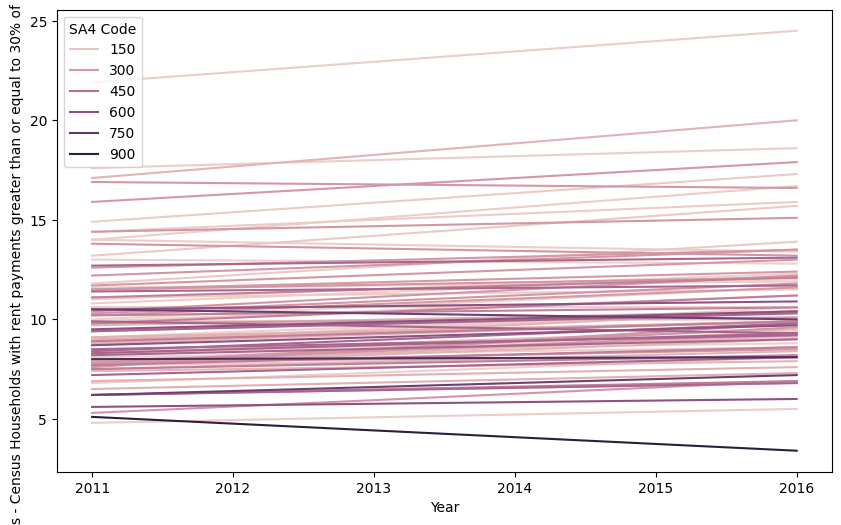

In [147]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=df_sudo, 
    x='Year', 
    y='Household Stress - Census Households with rent payments greater than or equal to 30% of household income (%)',
    hue='SA4 Code'
)